## **Proposed_model(ACGAN-WGAN-GP with EfficientNetV2B0)**

# Importing necessary Libraries and Modules

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

 *Various types of layers used to construct neural networks.*

*GlobalAveragePooling2D, Concatenate, PReLU, LeakyReLU, Embedding are the Specialized layers and activations used in deep learning models.*

In [6]:
from tensorflow.keras.layers import Reshape, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, Input, Lambda, GlobalAveragePooling2D, Concatenate, PReLU, LeakyReLU, Embedding, multiply
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.optimizers import Adam

*Classes for creating Keras models*

In [8]:
from tensorflow.keras.models import Sequential, Model

In [9]:
from tensorflow.keras.utils import to_categorical, load_img, img_to_array

*ImageDataGenerator is used for image data augmentation to improve the generalization of the model*

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

*Callbacks to monitor the training process and make adjustments like stopping early if no improvement or reducing the learning rate.*

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger

*os and os.listdir: Used for interacting with the operating system, such as handling directories and files*

In [15]:
import os
from os import listdir

*A library for creating progress bars, useful for tracking long-running operations*

In [17]:
from tqdm import tqdm

*Shutil is used for high-level file operations like copying files*

In [19]:
import shutil

In [22]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
import time
import itertools
from sklearn.utils import resample  # Import resample

*Functions for splitting datasets into training and testing sets and performing cross-validation*

In [24]:
from sklearn.model_selection import train_test_split, KFold

*Functions for evaluating the performance of models*

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Callbacks

*Number of Epochs*

In [29]:
epochs = 125

*EarlyStopping: This callback monitors the performance of the model on the validation dataset*

In [31]:
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=epochs,
                          verbose=1,
                          restore_best_weights=True)

*ReduceLROnPlateau: This callback reduces the learning rate when a metric has stopped improving*

In [33]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)

*CSVLogger: This callback streams epoch results to a CSV file*

In [35]:
csv_logger = CSVLogger('My_Model.log')

*Combining Callbacks*

In [37]:
callbacks = [earlystop, csv_logger, reduce_lr]

# Metrics and Loss Functions

*Intersection over Union (IoU): Measures the overlap between the predicted and true binary masks*

In [40]:
def iou(y_true, y_pred, smooth=0.5):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

*Sensitivity: Also known as recall, it measures the proportion of actual positives correctly identified*

In [42]:
def sensitivity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

*Specificity: Measures the proportion of actual negatives correctly identified*

In [44]:
def specificity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

*F1-Score: Harmonic mean of precision and recall.*
*Precision: Proportion of predicted positives that are actual positives.*
*Recall: Proportion of actual positives correctly identified.*

In [46]:
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

*Dice Coefficient: Measures the similarity between two samples, similar to IoU*

In [48]:
def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    dice_score = (2.0 * intersection + epsilon) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + epsilon)
    return dice_score

*Tversky Index: Generalization of the Dice coefficient that allows control over the penalty for false positives and false negatives*

In [50]:
def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

# Confusion Matrix Visualization

In [52]:
def confusion_matrix_img(y_pred, y_true, savename):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['benign', 'malignant']
    title='Confusion matrix'
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(savename)
    plt.show()

# Creating Directories for Augmented Data

*Sets a variable size to 128, to be used later for resizing images to 128x128 pixels*

In [55]:
size = 128

*Creating Directories*

In [57]:
os.makedirs('augmented/benign', exist_ok=True)
os.makedirs('augmented/malignant', exist_ok=True)

# Defining a Function to List All Files in a Directory

*getListOfFiles, takes a directory name as an input and returns a list of all files*

In [60]:
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

# Copying Benign Images to the Augmented Directory

*This will organize and prepare data for augmentation by copying only PNG images from the source directory ('/Users/renitalewis/Downloads/archive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign') to the target directory ('augmented/benign')*

In [63]:
files_benign = getListOfFiles('/Users/renitalewis/Downloads/archive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign')
for f in files_benign:
    if f.endswith('.png'):
        shutil.copy(f, 'augmented/benign')

# Copying Malignant Images to the Augmented Directory

*This will organize and prepare data for augmentation by copying only PNG images from the source directory ('/Users/renitalewis/Downloads/archive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant') to the target directory ('augmented/malignant')*

In [66]:
files_malignant = getListOfFiles('/Users/renitalewis/Downloads/archive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant')
for f in files_malignant:
    if f.endswith('.png'):
        shutil.copy(f, 'augmented/malignant')

# Listing Files in Augmented Directories

In [68]:
benign_images = getListOfFiles('augmented/benign')
malignent_images = getListOfFiles('augmented/malignant')

# Load and Display an Image

*Loading and Displaying a Benign Image*

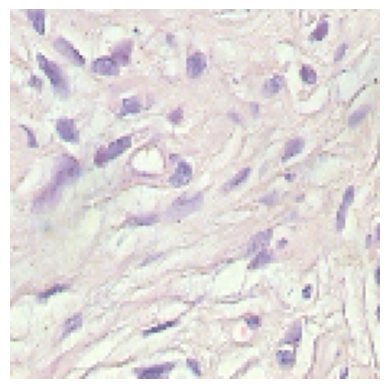

In [71]:
image_path = benign_images[9]
img = load_img(image_path, target_size=(size, size), color_mode='rgb')
img_array = img_to_array(img)
plt.imshow(img_array.astype('uint8'))
plt.axis('off')
plt.show()

*Loading and Displaying a Malignant Image*

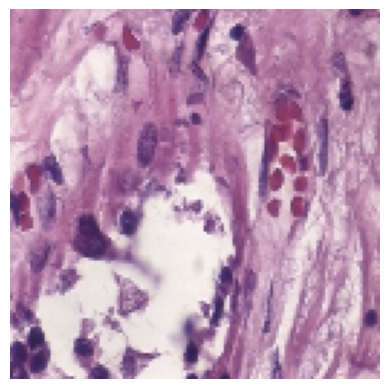

In [73]:
image_path = malignent_images[45]
img = load_img(image_path, target_size=(size, size), color_mode='rgb')
img_array = img_to_array(img)
plt.imshow(img_array.astype('uint8'))
plt.axis('off')
plt.show()

# Preparing the DataFrame

*Calculating Total Number of Images*

In [76]:
total_images = len(benign_images) + len(malignent_images)

*Creating the DataFrame*

In [78]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["image", "target"])

In [79]:
k = 0
for c, image_list in enumerate([benign_images, malignent_images]):
    for image_path in image_list:
        data.loc[k, "image"] = image_path
        data.loc[k, "target"] = c
        k += 1

print(data.shape)
print(data.head())

(7909, 2)
                                             image target
0  augmented/benign/SOB_B_F-14-23060CD-100-001.png      0
1  augmented/benign/SOB_B_TA-14-19854C-200-016.png      0
2  augmented/benign/SOB_B_TA-14-19854C-200-002.png      0
3    augmented/benign/SOB_B_F-14-25197-400-039.png      0
4   augmented/benign/SOB_B_F-14-14134E-100-007.png      0


# Balancing the Dataset

*Counting Class Instances*, *Resampling Benign Class*, *Concatenating DataFrames*, *Verifying the Balanced Dataset*

In [82]:
count_data = data["target"].value_counts()
ben_upsampled = resample(data[data['target']==0], n_samples=data[data['target']==1].shape[0], random_state=42)
up_sampled = pd.concat([data[data['target']==1], ben_upsampled])
up_sampled['target'].value_counts()

target
1    5429
0    5429
Name: count, dtype: int64

# Loading and Preprocessing Images

*Initializing Lists*

In [85]:
train_image = []
y = []

*Loading Images with Progress Bar*

In [87]:
for i in tqdm(range(up_sampled.shape[0])):
    img = tf.keras.utils.load_img(up_sampled['image'].iloc[i], target_size=(size, size), color_mode='rgb')
    img = tf.keras.utils.img_to_array(img)
    img = img / 255.0
    train_image.append(img)

100%|████████████████████████████████████| 10858/10858 [01:06<00:00, 164.46it/s]


*Converting Lists to Arrays*

In [89]:
X = np.array(train_image)
y = up_sampled.iloc[:, -1].values

# K-Fold Cross-Validation Split

*Initializing K-Fold*

In [92]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

*The First Split*

In [94]:
for train_index, test_index in kf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

*The Second Split (Validation Split)*

In [96]:
for train_index, test_index in kf.split(X_test, y_test):
    X2_test, X_val, y2_test, y_val = X_test[train_index], X_test[test_index], y_test[train_index], y_test[test_index]

# One-Hot Encoding Labels

In [98]:
Y_train = to_categorical(y_train, 2)
Y_test = to_categorical(y2_test, 2)
Y_val = to_categorical(y_val, 2)

print(X_train.shape)
print(X2_test.shape)
print(X_val.shape)

(9773, 128, 128, 3)
(977, 128, 128, 3)
(108, 128, 128, 3)


# Data Augmentation

In [100]:
data_gen = ImageDataGenerator(
    zoom_range=1.2,  
    rotation_range=90,
    width_shift_range=0.5,
    height_shift_range=0.5,
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,  # randomly flip images
)

*Fitting Data Generators*

In [102]:
data_gen.fit(X_train)
data_gen.fit(X_val)
data_gen.fit(X2_test)

# Wasserstein Loss Function and Gradient Penalty Loss Function

*wasserstein_loss, this function encourages the model to differentiate between real and fake samples by adjusting scores in a way that reflects the Wasserstein distance.* <br> *gradient_penalty_loss, enforces constraints on the gradients to stabilize training, ensuring the gradients do not explode or vanish by penalizing deviations from a norm of 1.0.*

In [104]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

def gradient_penalty_loss(y_true, y_pred, averaged_samples, lambda_gp):
    gradients = K.gradients(y_pred, averaged_samples)[0]
    gradients_sqr = K.square(gradients)
    gradient_penalty = K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
    return K.mean((gradient_penalty - 1.0) ** 2) * lambda_gp

# The Generator Architecture

In [106]:
def build_generator(noise_dim, num_classes, img_shape):
    noise = Input(shape=(noise_dim,))
    label = Input(shape=(1,), dtype='int32')
    
    label_embedding = Flatten()(Embedding(num_classes, noise_dim)(label))
    model_input = multiply([noise, label_embedding])
    
    x = Dense(256)(model_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(np.prod(img_shape), activation='tanh')(x)
    img = Reshape(img_shape)(x)
    
    return Model([noise, label], img)

# The Discriminator Architecture

In [108]:
def build_discriminator(img_shape, num_classes):
    img = Input(shape=img_shape)
    
    x = Flatten()(img)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    validity = Dense(1, name='validity')(x)
    label = Dense(num_classes, activation='softmax', name='label')(x)
    
    return Model(img, [validity, label])

# Setting Image Shape and Noise Dimension

*Image Shape*

In [111]:
img_shape = (size, size, 3)

*Noise Dimension*

In [113]:
noise_dim = 100

*Number of Classes*

In [115]:
num_classes = 2

*Gradient Penalty Hyperparameter*

In [117]:
lambda_gp = 10

# Building the Discriminator

In [119]:
discriminator = build_discriminator(img_shape, num_classes)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


# Compiling the Discriminator

In [121]:
discriminator.compile(loss={'validity': wasserstein_loss, 'label': 'sparse_categorical_crossentropy'},
                      optimizer=Adam(0.0002, 0.5),
                      metrics={'label': 'accuracy'})  # Updated metrics

# Building the Generator

In [123]:
generator = build_generator(noise_dim, num_classes, img_shape)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


# Generator Inputs and Outputs

In [125]:
noise = Input(shape=(noise_dim,))
label = Input(shape=(1,))
img = generator([noise, label])

# Setting Up the Combined Model

*Freezing Discriminator Layers*

In [128]:
discriminator.trainable = False

*Passing Generated Images to Discriminator*

In [130]:
validity, target_label = discriminator(img)

*Defining the Combined Model*

In [132]:
gan = Model([noise, label], [validity, target_label])

*Compiling the Combined Model*

In [134]:
gan.compile(loss=[wasserstein_loss, 'sparse_categorical_crossentropy'],
            optimizer=Adam(0.0002, 0.5))

# Training the ACGAN-WGAN-GP

*Defining the Training Function*

*The training Loop*

In [138]:
def train_acgan_wgan_gp(epochs, batch_size, save_interval):
    X_train_wgan = X_train * 2 - 1  # Normalize to [-1, 1] for tanh activation
    valid = -np.ones((batch_size, 1), dtype=np.float32)
    fake = np.ones((batch_size, 1), dtype=np.float32)
    for epoch in range(epochs):
        for _ in range(5):
            idx = np.random.randint(0, X_train_wgan.shape[0], batch_size)
            imgs, labels = X_train_wgan[idx], y_train[idx]
            
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            gen_labels = np.random.randint(0, num_classes, batch_size)
            gen_imgs = generator.predict([noise, gen_labels])
            
            d_loss_real = discriminator.train_on_batch(imgs, [valid, labels.astype(np.float32)])
            d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, gen_labels.astype(np.float32)])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            sampled_labels = np.random.randint(0, num_classes, batch_size)
            valid = -np.ones((batch_size, 1), dtype=np.float32)
            
            g_loss = gan.train_on_batch([noise, sampled_labels], [valid, sampled_labels.astype(np.float32)])
        
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss[0]}]")
        
        if epoch % save_interval == 0:
            save_imgs(epoch)

# Saving Generated Images

*Defining the Save Images Function*

In [141]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, noise_dim))
    sampled_labels = np.random.randint(0, num_classes, r * c)
    gen_imgs = generator.predict([noise, sampled_labels])
    
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/acgan_wgan_%d.png" % epoch)
    plt.close()

# Calling the Training Function

In [143]:
train_acgan_wgan_gp(epochs=125, batch_size=4, save_interval=20)  

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0 [D loss: 1.0190486907958984 | D accuracy: 69.72222328186035] [G loss: 1.0100488662719727]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1 [D loss: 1.0150829553604126 | D accuracy: 68.58552694320679] [G loss: 1.0149887800216675]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2 [D loss: 1.082747459411621 | D accuracy: 64.3965482711792] [G loss: 1.083844542503357]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━

# Function Definition

In [145]:
def generate_images(generator, num_images, noise_dim, num_classes):
    noise = np.random.normal(0, 1, (num_images, noise_dim))
    sampled_labels = np.random.randint(0, num_classes, num_images)
    gen_imgs = generator.predict([noise, sampled_labels])
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]
    return gen_imgs

# Generating a Set of Synthetic Images

*Specifying Number of Synthetic Images*

In [148]:
num_synthetic_images = 1000

*Generating Synthetic Images*

In [150]:
synthetic_images = generate_images(generator, num_synthetic_images, noise_dim, num_classes)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


# Adding Synthetic Images to the Training Set

*Concatenate Synthetic Images to Training Set*

In [153]:
X_train_augmented = np.concatenate((X_train, synthetic_images))

*Concatenate Labels for Synthetic Images*

In [155]:
y_train_augmented = np.concatenate((y_train, np.full((num_synthetic_images,), 1)))  # Assuming class 1 for synthetic images

# One-Hot Encoding Labels

In [157]:
Y_train_augmented = to_categorical(y_train_augmented, 2)

# Setting Up Distributed Training

Initializing MirroredStrategy and Printing the Number of Devices

In [160]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


# Function Definitions

*Bottleneck with EfficientNet*

In [163]:
def bottleneck0(inputs):
    backbone = tf.keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
    x = backbone(inputs)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)  # Bottleneck layer with EfficientNet
    x = Flatten()(x)
    return x

*Neck Section*

In [165]:
def neck_section(inputs):
    x = Conv2D(256, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = PReLU()(x)  # Use PReLU directly as a layer
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = Flatten()(x)
    return x

*Vision Transform*

In [167]:
def vision_transform(inputs, patch_size):
    x = Reshape((patch_size[0], patch_size[1], -1))(inputs)
    x = Lambda(lambda image: tf.cast(image, 'float32') / 255.0)(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    return x

*Creating the Model*

In [169]:
def create_model(input_shape, num_classes, patch_size):
    inputs = Input(shape=input_shape)
    efficientnet_bottleneck = bottleneck0(inputs)
    patches_transform = vision_transform(inputs, patch_size)
    neck = neck_section(inputs)
    merged = Concatenate()([efficientnet_bottleneck, patches_transform, neck])
    outputs = Dense(num_classes, activation='softmax')(merged)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Model Setup and Compilation

*Model Parameters*

In [172]:
input_shape = (size, size, 3)
num_classes = 2
patch_size = (32, 32)
batch_size = 32  # Reduced batch size to 32

*Distributed Training Strategy*

In [174]:
with strategy.scope():
    model = create_model(input_shape, num_classes, patch_size)
    model.compile(loss="categorical_crossentropy",
                  optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.AUC(name='AUC'),
                           f1_score, specificity, sensitivity, iou, tversky])

# Model Summary

*Printing The Model Information*

In [177]:
print(model.input_shape)
print(model.output_shape)
model.summary()

(None, 128, 128, 3)
(None, 2)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 32, 32,    │          0 │ input_layer_5[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 32, 32,    │          0 │ reshape_1[0][0]   │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 30, 30,    │     27,712 │ lambda[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 4, 4,      │  5,919,312 │ input_layer_5[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     37,888 │ input_layer_5[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 12, 12,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1280)      │      5,120 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 10, 10,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 64, 64,    │  1,048,576 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    327,936 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 5, 5, 128) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ p_re_lu[0][0]     │
│ (MaxPooling2D)      │ 256)              │            │                 

 Total params: 8,157,138 (31.12 MB)

 Trainable params: 8,093,458 (30.87 MB)

 Non-trainable params: 63,680 (248.75 KB)

# Measuring Training Time

*Record Start Time*

In [180]:
start_time = time.time()

# Training the Model

In [182]:
history = model.fit(data_gen.flow(X_train_augmented, Y_train_augmented,
                                       batch_size=batch_size, 
                                       seed=27,
                                       shuffle=True),
                    callbacks=callbacks,
                    epochs=50,
                    steps_per_epoch=X_train_augmented.shape[0] // batch_size,
                    validation_data=data_gen.flow(X_val, Y_val,
                                       batch_size=batch_size, 
                                       seed=27,
                                       shuffle=True))

Epoch 1/50


2024-08-09 13:07:36.721087: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.6960 - accuracy: 0.6753 - f1_score: 0.6753 - iou: 0.5255 - loss: 10.9362 - precision: 0.6753 - recall: 0.6753 - sensitivity: 0.6753 - specificity: 0.6753 - tversky: 0.6855

2024-08-09 13:14:01.443755: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-08-09 13:14:03.318113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 387s 1s/step - AUC: 0.6962 - accuracy: 0.6754 - f1_score: 0.6754 - iou: 0.5256 - loss: 10.9236 - precision: 0.6754 - recall: 0.6754 - sensitivity: 0.6754 - specificity: 0.6754 - tversky: 0.6856 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5703 - val_iou: 0.4226 - val_loss: 13.6999 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5703 - val_specificity: 0.5703 - val_tversky: 0.5862 - learning_rate: 0.0010
Epoch 2/50


2024-08-09 13:14:03.583416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 6:54 1s/step - AUC: 0.9111 - accuracy: 0.8438 - f1_score: 0.8437 - iou: 0.7317 - loss: 1.3056 - precision: 0.8438 - recall: 0.8438 - sensitivity: 0.8438 - specificity: 0.8438 - tversky: 0.8474

2024-08-09 13:14:04.829565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]
/opt/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9111 - accuracy: 0.8438 - f1_score: 0.4231 - iou: 0.3669 - loss: 1.3056 - precision: 0.8438 - recall: 0.8438 - sensitivity: 0.4231 - specificity: 0.4231 - tversky: 0.4250 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5443 - val_iou: 0.3835 - val_loss: 21.4511 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5443 - val_specificity: 0.5443 - val_tversky: 0.5629 - learning_rate: 0.0010
Epoch 3/50


2024-08-09 13:14:05.613533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.7612 - accuracy: 0.7336 - f1_score: 0.7332 - iou: 0.5925 - loss: 5.0273 - precision: 0.7336 - recall: 0.7336 - sensitivity: 0.7332 - specificity: 0.7332 - tversky: 0.7414

2024-08-09 13:20:54.194613: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - AUC: 0.7612 - accuracy: 0.7336 - f1_score: 0.7332 - iou: 0.5925 - loss: 5.0284 - precision: 0.7336 - recall: 0.7336 - sensitivity: 0.7332 - specificity: 0.7332 - tversky: 0.7414 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5312 - val_iou: 0.3721 - val_loss: 35.5638 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5312 - val_specificity: 0.5312 - val_tversky: 0.5513 - learning_rate: 0.0010
Epoch 4/50


2024-08-09 13:20:54.962015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 13:20:55.094349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 8:28 2s/step - AUC: 0.7983 - accuracy: 0.7500 - f1_score: 0.7500 - iou: 0.6053 - loss: 2.8146 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.7500 - specificity: 0.7500 - tversky: 0.7579

2024-08-09 13:20:56.623075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7983 - accuracy: 0.7500 - f1_score: 0.3761 - iou: 0.3036 - loss: 2.8146 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.3761 - specificity: 0.3761 - tversky: 0.3801 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5443 - val_iou: 0.3873 - val_loss: 42.6058 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5443 - val_specificity: 0.5443 - val_tversky: 0.5629 - learning_rate: 0.0010
Epoch 5/50


2024-08-09 13:20:57.607198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.7695 - accuracy: 0.7446 - f1_score: 0.7444 - iou: 0.6044 - loss: 4.9929 - precision: 0.7446 - recall: 0.7446 - sensitivity: 0.7444 - specificity: 0.7444 - tversky: 0.7508

2024-08-09 13:27:36.572144: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-08-09 13:27:37.348553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 400s 1s/step - AUC: 0.7696 - accuracy: 0.7446 - f1_score: 0.7444 - iou: 0.6045 - loss: 4.9903 - precision: 0.7446 - recall: 0.7446 - sensitivity: 0.7444 - specificity: 0.7444 - tversky: 0.7508 - val_AUC: 0.4595 - val_accuracy: 0.5000 - val_f1_score: 0.5000 - val_iou: 0.3353 - val_loss: 7.4408 - val_precision: 0.5000 - val_recall: 0.5000 - val_sensitivity: 0.5000 - val_specificity: 0.5000 - val_tversky: 0.5124 - learning_rate: 0.0010
Epoch 6/50


2024-08-09 13:27:37.564128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 7:39 1s/step - AUC: 0.6602 - accuracy: 0.6250 - f1_score: 0.6250 - iou: 0.4622 - loss: 5.3276 - precision: 0.6250 - recall: 0.6250 - sensitivity: 0.6250 - specificity: 0.6250 - tversky: 0.6378

2024-08-09 13:27:38.946661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.6602 - accuracy: 0.6250 - f1_score: 0.3134 - iou: 0.2318 - loss: 5.3276 - precision: 0.6250 - recall: 0.6250 - sensitivity: 0.3134 - specificity: 0.3134 - tversky: 0.3198 - val_AUC: 0.4869 - val_accuracy: 0.4815 - val_f1_score: 0.4974 - val_iou: 0.3461 - val_loss: 5.6255 - val_precision: 0.4815 - val_recall: 0.4815 - val_sensitivity: 0.4974 - val_specificity: 0.4974 - val_tversky: 0.5178 - learning_rate: 0.0010
Epoch 7/50


2024-08-09 13:27:40.002120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.8108 - accuracy: 0.7742 - f1_score: 0.7740 - iou: 0.6425 - loss: 3.1900 - precision: 0.7742 - recall: 0.7742 - sensitivity: 0.7740 - specificity: 0.7740 - tversky: 0.7804

2024-08-09 13:34:33.747610: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - AUC: 0.8108 - accuracy: 0.7742 - f1_score: 0.7740 - iou: 0.6425 - loss: 3.1895 - precision: 0.7742 - recall: 0.7742 - sensitivity: 0.7740 - specificity: 0.7740 - tversky: 0.7804 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5573 - val_iou: 0.3986 - val_loss: 32.2664 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5573 - val_specificity: 0.5573 - val_tversky: 0.5746 - learning_rate: 0.0010
Epoch 8/50


2024-08-09 13:34:34.520561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 13:34:34.657020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 7:50 1s/step - AUC: 0.7676 - accuracy: 0.7812 - f1_score: 0.7812 - iou: 0.6350 - loss: 4.2723 - precision: 0.7812 - recall: 0.7812 - sensitivity: 0.7812 - specificity: 0.7812 - tversky: 0.7802

2024-08-09 13:34:36.065375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7676 - accuracy: 0.7812 - f1_score: 0.3918 - iou: 0.3185 - loss: 4.2723 - precision: 0.7812 - recall: 0.7812 - sensitivity: 0.3918 - specificity: 0.3918 - tversky: 0.3912 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5052 - val_iou: 0.3576 - val_loss: 34.3824 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5052 - val_specificity: 0.5052 - val_tversky: 0.5280 - learning_rate: 0.0010
Epoch 9/50


2024-08-09 13:34:36.985550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.8386 - accuracy: 0.7878 - f1_score: 0.7877 - iou: 0.6602 - loss: 1.8945 - precision: 0.7878 - recall: 0.7878 - sensitivity: 0.7877 - specificity: 0.7877 - tversky: 0.7939

2024-08-09 13:41:22.119842: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - AUC: 0.8386 - accuracy: 0.7878 - f1_score: 0.7878 - iou: 0.6602 - loss: 1.8944 - precision: 0.7878 - recall: 0.7878 - sensitivity: 0.7878 - specificity: 0.7878 - tversky: 0.7940 - val_AUC: 0.2817 - val_accuracy: 0.3519 - val_f1_score: 0.3359 - val_iou: 0.2168 - val_loss: 3.7688 - val_precision: 0.3519 - val_recall: 0.3519 - val_sensitivity: 0.3359 - val_specificity: 0.3359 - val_tversky: 0.3694 - learning_rate: 0.0010
Epoch 10/50


2024-08-09 13:41:22.816663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 13:41:23.004732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 6:49 1s/step - AUC: 0.7012 - accuracy: 0.6562 - f1_score: 0.6562 - iou: 0.4996 - loss: 3.2835 - precision: 0.6562 - recall: 0.6562 - sensitivity: 0.6562 - specificity: 0.6562 - tversky: 0.6714

2024-08-09 13:41:24.230100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7012 - accuracy: 0.6562 - f1_score: 0.3291 - iou: 0.2505 - loss: 3.2835 - precision: 0.6562 - recall: 0.6562 - sensitivity: 0.3291 - specificity: 0.3291 - tversky: 0.3367 - val_AUC: 0.2714 - val_accuracy: 0.3333 - val_f1_score: 0.3073 - val_iou: 0.1968 - val_loss: 5.8154 - val_precision: 0.3333 - val_recall: 0.3333 - val_sensitivity: 0.3073 - val_specificity: 0.3073 - val_tversky: 0.3346 - learning_rate: 0.0010
Epoch 11/50


2024-08-09 13:41:25.011072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.8473 - accuracy: 0.7981 - f1_score: 0.7980 - iou: 0.6671 - loss: 1.6263 - precision: 0.7981 - recall: 0.7981 - sensitivity: 0.7980 - specificity: 0.7980 - tversky: 0.7991

2024-08-09 13:48:06.743314: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - AUC: 0.8473 - accuracy: 0.7981 - f1_score: 0.7981 - iou: 0.6671 - loss: 1.6260 - precision: 0.7981 - recall: 0.7981 - sensitivity: 0.7981 - specificity: 0.7981 - tversky: 0.7991 - val_AUC: 0.6885 - val_accuracy: 0.6574 - val_f1_score: 0.6068 - val_iou: 0.4727 - val_loss: 5.7126 - val_precision: 0.6574 - val_recall: 0.6574 - val_sensitivity: 0.6068 - val_specificity: 0.6068 - val_tversky: 0.6331 - learning_rate: 0.0010
Epoch 12/50


2024-08-09 13:48:07.463222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 13:48:07.584105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 7:14 1s/step - AUC: 0.8691 - accuracy: 0.8125 - f1_score: 0.8125 - iou: 0.6608 - loss: 1.0147 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.8125 - specificity: 0.8125 - tversky: 0.7989

2024-08-09 13:48:08.891037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8691 - accuracy: 0.8125 - f1_score: 0.4075 - iou: 0.3314 - loss: 1.0147 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.4075 - specificity: 0.4075 - tversky: 0.4006 - val_AUC: 0.7732 - val_accuracy: 0.7593 - val_f1_score: 0.7318 - val_iou: 0.5802 - val_loss: 3.4083 - val_precision: 0.7593 - val_recall: 0.7593 - val_sensitivity: 0.7318 - val_specificity: 0.7318 - val_tversky: 0.7352 - learning_rate: 0.0010
Epoch 13/50


2024-08-09 13:48:09.699225: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.8628 - accuracy: 0.8123 - f1_score: 0.8123 - iou: 0.6871 - loss: 1.4518 - precision: 0.8123 - recall: 0.8123 - sensitivity: 0.8123 - specificity: 0.8123 - tversky: 0.8131

2024-08-09 13:55:14.301451: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 425s 1s/step - AUC: 0.8629 - accuracy: 0.8123 - f1_score: 0.8123 - iou: 0.6872 - loss: 1.4517 - precision: 0.8123 - recall: 0.8123 - sensitivity: 0.8123 - specificity: 0.8123 - tversky: 0.8131 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5573 - val_iou: 0.4029 - val_loss: 17.8340 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5573 - val_specificity: 0.5573 - val_tversky: 0.5746 - learning_rate: 0.0010
Epoch 14/50


2024-08-09 13:55:15.058640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 13:55:15.180323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 8:16 1s/step - AUC: 0.7891 - accuracy: 0.7500 - f1_score: 0.7500 - iou: 0.5940 - loss: 1.8155 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.7500 - specificity: 0.7500 - tversky: 0.7492

2024-08-09 13:55:16.675858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.7891 - accuracy: 0.7500 - f1_score: 0.3761 - iou: 0.2979 - loss: 1.8155 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.3761 - specificity: 0.3761 - tversky: 0.3757 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5312 - val_iou: 0.3715 - val_loss: 16.5900 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5312 - val_specificity: 0.5312 - val_tversky: 0.5513 - learning_rate: 0.0010
Epoch 15/50


2024-08-09 13:55:17.508052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.8769 - accuracy: 0.8099 - f1_score: 0.8099 - iou: 0.6834 - loss: 1.0859 - precision: 0.8099 - recall: 0.8099 - sensitivity: 0.8099 - specificity: 0.8099 - tversky: 0.8109

2024-08-09 14:02:05.360396: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - AUC: 0.8769 - accuracy: 0.8099 - f1_score: 0.8099 - iou: 0.6834 - loss: 1.0861 - precision: 0.8099 - recall: 0.8099 - sensitivity: 0.8099 - specificity: 0.8099 - tversky: 0.8109 - val_AUC: 0.5526 - val_accuracy: 0.5463 - val_f1_score: 0.5391 - val_iou: 0.3774 - val_loss: 7.2766 - val_precision: 0.5463 - val_recall: 0.5463 - val_sensitivity: 0.5391 - val_specificity: 0.5391 - val_tversky: 0.5559 - learning_rate: 0.0010
Epoch 16/50


2024-08-09 14:02:06.243347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 14:02:06.372703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 9:30 2s/step - AUC: 0.9668 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.7585 - loss: 0.2179 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8647

2024-08-09 14:02:08.085824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9668 - accuracy: 0.8750 - f1_score: 0.4388 - iou: 0.3804 - loss: 0.2179 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4388 - specificity: 0.4388 - tversky: 0.4336 - val_AUC: 0.5900 - val_accuracy: 0.5741 - val_f1_score: 0.5755 - val_iou: 0.4213 - val_loss: 4.7983 - val_precision: 0.5741 - val_recall: 0.5741 - val_sensitivity: 0.5755 - val_specificity: 0.5755 - val_tversky: 0.5962 - learning_rate: 0.0010
Epoch 17/50


2024-08-09 14:02:08.918808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.8746 - accuracy: 0.8067 - f1_score: 0.8068 - iou: 0.6789 - loss: 1.0171 - precision: 0.8067 - recall: 0.8067 - sensitivity: 0.8068 - specificity: 0.8068 - tversky: 0.8076

2024-08-09 14:08:17.589743: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - AUC: 0.8746 - accuracy: 0.8067 - f1_score: 0.8068 - iou: 0.6790 - loss: 1.0168 - precision: 0.8067 - recall: 0.8067 - sensitivity: 0.8068 - specificity: 0.8068 - tversky: 0.8076 - val_AUC: 0.6263 - val_accuracy: 0.5278 - val_f1_score: 0.5365 - val_iou: 0.3993 - val_loss: 2.8776 - val_precision: 0.5278 - val_recall: 0.5278 - val_sensitivity: 0.5365 - val_specificity: 0.5365 - val_tversky: 0.5792 - learning_rate: 0.0010
Epoch 18/50


2024-08-09 14:08:18.320989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 14:08:18.504257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 7:21 1s/step - AUC: 0.9521 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.7479 - loss: 0.3542 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8580

2024-08-09 14:08:19.829063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9521 - accuracy: 0.8750 - f1_score: 0.4388 - iou: 0.3751 - loss: 0.3542 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4388 - specificity: 0.4388 - tversky: 0.4303 - val_AUC: 0.7046 - val_accuracy: 0.6204 - val_f1_score: 0.6406 - val_iou: 0.4969 - val_loss: 1.7980 - val_precision: 0.6204 - val_recall: 0.6204 - val_sensitivity: 0.6406 - val_specificity: 0.6406 - val_tversky: 0.6646 - learning_rate: 0.0010
Epoch 19/50


2024-08-09 14:08:20.626006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.8918 - accuracy: 0.8203 - f1_score: 0.8201 - iou: 0.6885 - loss: 0.7797 - precision: 0.8203 - recall: 0.8203 - sensitivity: 0.8201 - specificity: 0.8201 - tversky: 0.8145

2024-08-09 14:14:29.260910: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - AUC: 0.8918 - accuracy: 0.8203 - f1_score: 0.8201 - iou: 0.6885 - loss: 0.7797 - precision: 0.8203 - recall: 0.8203 - sensitivity: 0.8201 - specificity: 0.8201 - tversky: 0.8145 - val_AUC: 0.5758 - val_accuracy: 0.5463 - val_f1_score: 0.5130 - val_iou: 0.3595 - val_loss: 2.9161 - val_precision: 0.5463 - val_recall: 0.5463 - val_sensitivity: 0.5130 - val_specificity: 0.5130 - val_tversky: 0.5328 - learning_rate: 0.0010
Epoch 20/50


2024-08-09 14:14:29.975420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 14:14:30.092576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 6:37 1s/step - AUC: 0.9365 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.7511 - loss: 0.3773 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8600

2024-08-09 14:14:31.287545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9365 - accuracy: 0.8750 - f1_score: 0.4388 - iou: 0.3767 - loss: 0.3773 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4388 - specificity: 0.4388 - tversky: 0.4313 - val_AUC: 0.6403 - val_accuracy: 0.5741 - val_f1_score: 0.5755 - val_iou: 0.4243 - val_loss: 2.1295 - val_precision: 0.5741 - val_recall: 0.5741 - val_sensitivity: 0.5755 - val_specificity: 0.5755 - val_tversky: 0.5965 - learning_rate: 0.0010
Epoch 21/50


2024-08-09 14:14:32.069040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9170 - accuracy: 0.8479 - f1_score: 0.8480 - iou: 0.7174 - loss: 0.5372 - precision: 0.8479 - recall: 0.8479 - sensitivity: 0.8480 - specificity: 0.8480 - tversky: 0.8348

2024-08-09 14:21:05.689273: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - AUC: 0.9170 - accuracy: 0.8479 - f1_score: 0.8480 - iou: 0.7174 - loss: 0.5372 - precision: 0.8479 - recall: 0.8479 - sensitivity: 0.8480 - specificity: 0.8480 - tversky: 0.8348 - val_AUC: 0.5660 - val_accuracy: 0.5370 - val_f1_score: 0.5443 - val_iou: 0.3887 - val_loss: 3.9402 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5443 - val_specificity: 0.5443 - val_tversky: 0.5657 - learning_rate: 0.0010
Epoch 22/50


2024-08-09 14:21:06.458746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 14:21:06.581757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 5:56 1s/step - AUC: 0.9375 - accuracy: 0.8125 - f1_score: 0.8125 - iou: 0.6954 - loss: 0.4247 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.8125 - specificity: 0.8125 - tversky: 0.8230

2024-08-09 14:21:07.656639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9375 - accuracy: 0.8125 - f1_score: 0.4075 - iou: 0.3487 - loss: 0.4247 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.4075 - specificity: 0.4075 - tversky: 0.4127 - val_AUC: 0.5544 - val_accuracy: 0.5370 - val_f1_score: 0.5182 - val_iou: 0.3655 - val_loss: 4.9683 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5182 - val_specificity: 0.5182 - val_tversky: 0.5417 - learning_rate: 0.0010
Epoch 23/50


2024-08-09 14:21:08.469548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9240 - accuracy: 0.8496 - f1_score: 0.8496 - iou: 0.7193 - loss: 0.4700 - precision: 0.8496 - recall: 0.8496 - sensitivity: 0.8496 - specificity: 0.8496 - tversky: 0.8364

2024-08-09 14:27:31.799054: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 23: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
336/336 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - AUC: 0.9240 - accuracy: 0.8496 - f1_score: 0.8495 - iou: 0.7193 - loss: 0.4700 - precision: 0.8496 - recall: 0.8496 - sensitivity: 0.8495 - specificity: 0.8495 - tversky: 0.8364 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5443 - val_iou: 0.3844 - val_loss: 13.9402 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5443 - val_specificity: 0.5443 - val_tversky: 0.5629 - learning_rate: 0.0010
Epoch 24/50


2024-08-09 14:27:32.553011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 14:27:32.677388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 6:05 1s/step - AUC: 0.8877 - accuracy: 0.7500 - f1_score: 0.7500 - iou: 0.6151 - loss: 0.5504 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.7500 - specificity: 0.7500 - tversky: 0.7653

2024-08-09 14:27:33.782491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.8877 - accuracy: 0.7500 - f1_score: 0.3761 - iou: 0.3085 - loss: 0.5504 - precision: 0.7500 - recall: 0.7500 - sensitivity: 0.3761 - specificity: 0.3761 - tversky: 0.3838 - val_AUC: 0.5370 - val_accuracy: 0.5370 - val_f1_score: 0.5312 - val_iou: 0.3727 - val_loss: 14.1676 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5312 - val_specificity: 0.5312 - val_tversky: 0.5513 - learning_rate: 2.0000e-04
Epoch 25/50


2024-08-09 14:27:34.594387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9311 - accuracy: 0.8621 - f1_score: 0.8621 - iou: 0.7242 - loss: 0.3979 - precision: 0.8621 - recall: 0.8621 - sensitivity: 0.8621 - specificity: 0.8621 - tversky: 0.8394

2024-08-09 14:34:43.874042: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-08-09 14:34:44.785752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 430s 1s/step - AUC: 0.9311 - accuracy: 0.8622 - f1_score: 0.8621 - iou: 0.7242 - loss: 0.3977 - precision: 0.8622 - recall: 0.8622 - sensitivity: 0.8621 - specificity: 0.8621 - tversky: 0.8395 - val_AUC: 0.8355 - val_accuracy: 0.7870 - val_f1_score: 0.7812 - val_iou: 0.5837 - val_loss: 0.6254 - val_precision: 0.7870 - val_recall: 0.7870 - val_sensitivity: 0.7812 - val_specificity: 0.7812 - val_tversky: 0.7426 - learning_rate: 2.0000e-04
Epoch 26/50


2024-08-09 14:34:45.001458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 8:35 2s/step - AUC: 0.9766 - accuracy: 0.9375 - f1_score: 0.9375 - iou: 0.8089 - loss: 0.1959 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.9375 - specificity: 0.9375 - tversky: 0.8959

2024-08-09 14:34:46.552007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9766 - accuracy: 0.9375 - f1_score: 0.4701 - iou: 0.4056 - loss: 0.1959 - precision: 0.9375 - recall: 0.9375 - sensitivity: 0.4701 - specificity: 0.4701 - tversky: 0.4493 - val_AUC: 0.8508 - val_accuracy: 0.7315 - val_f1_score: 0.6953 - val_iou: 0.5619 - val_loss: 0.5573 - val_precision: 0.7315 - val_recall: 0.7315 - val_sensitivity: 0.6953 - val_specificity: 0.6953 - val_tversky: 0.7205 - learning_rate: 2.0000e-04
Epoch 27/50


2024-08-09 14:34:47.455277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9506 - accuracy: 0.8794 - f1_score: 0.8793 - iou: 0.7364 - loss: 0.2997 - precision: 0.8794 - recall: 0.8794 - sensitivity: 0.8793 - specificity: 0.8793 - tversky: 0.8488

2024-08-09 14:42:09.027757: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 443s 1s/step - AUC: 0.9506 - accuracy: 0.8794 - f1_score: 0.8794 - iou: 0.7364 - loss: 0.2997 - precision: 0.8794 - recall: 0.8794 - sensitivity: 0.8794 - specificity: 0.8794 - tversky: 0.8488 - val_AUC: 0.9134 - val_accuracy: 0.8519 - val_f1_score: 0.8620 - val_iou: 0.6823 - val_loss: 0.3993 - val_precision: 0.8519 - val_recall: 0.8519 - val_sensitivity: 0.8620 - val_specificity: 0.8620 - val_tversky: 0.8139 - learning_rate: 2.0000e-04


2024-08-09 14:42:09.932649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


Epoch 28/50


2024-08-09 14:42:10.157465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 9:17 2s/step - AUC: 0.8818 - accuracy: 0.7812 - f1_score: 0.7812 - iou: 0.6392 - loss: 0.5311 - precision: 0.7812 - recall: 0.7812 - sensitivity: 0.7812 - specificity: 0.7812 - tversky: 0.7832

2024-08-09 14:42:11.830051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8818 - accuracy: 0.7812 - f1_score: 0.3918 - iou: 0.3206 - loss: 0.5311 - precision: 0.7812 - recall: 0.7812 - sensitivity: 0.3918 - specificity: 0.3918 - tversky: 0.3928 - val_AUC: 0.9365 - val_accuracy: 0.8426 - val_f1_score: 0.8411 - val_iou: 0.7101 - val_loss: 0.3365 - val_precision: 0.8426 - val_recall: 0.8426 - val_sensitivity: 0.8411 - val_specificity: 0.8411 - val_tversky: 0.8307 - learning_rate: 2.0000e-04
Epoch 29/50


2024-08-09 14:42:12.710582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9525 - accuracy: 0.8823 - f1_score: 0.8824 - iou: 0.7361 - loss: 0.2863 - precision: 0.8823 - recall: 0.8823 - sensitivity: 0.8824 - specificity: 0.8824 - tversky: 0.8485

2024-08-09 14:49:21.807483: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 430s 1s/step - AUC: 0.9525 - accuracy: 0.8824 - f1_score: 0.8824 - iou: 0.7362 - loss: 0.2863 - precision: 0.8824 - recall: 0.8824 - sensitivity: 0.8824 - specificity: 0.8824 - tversky: 0.8486 - val_AUC: 0.9666 - val_accuracy: 0.9167 - val_f1_score: 0.9297 - val_iou: 0.8137 - val_loss: 0.2371 - val_precision: 0.9167 - val_recall: 0.9167 - val_sensitivity: 0.9297 - val_specificity: 0.9297 - val_tversky: 0.8967 - learning_rate: 2.0000e-04
Epoch 30/50


2024-08-09 14:49:22.610846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 14:49:22.820674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 7:42 1s/step - AUC: 0.9062 - accuracy: 0.8125 - f1_score: 0.8125 - iou: 0.6467 - loss: 0.4020 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.8125 - specificity: 0.8125 - tversky: 0.7887

2024-08-09 14:49:24.208723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9062 - accuracy: 0.8125 - f1_score: 0.4075 - iou: 0.3243 - loss: 0.4020 - precision: 0.8125 - recall: 0.8125 - sensitivity: 0.4075 - specificity: 0.4075 - tversky: 0.3955 - val_AUC: 0.9593 - val_accuracy: 0.8889 - val_f1_score: 0.9062 - val_iou: 0.7694 - val_loss: 0.2612 - val_precision: 0.8889 - val_recall: 0.8889 - val_sensitivity: 0.9062 - val_specificity: 0.9062 - val_tversky: 0.8695 - learning_rate: 2.0000e-04
Epoch 31/50


2024-08-09 14:49:25.097406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9535 - accuracy: 0.8860 - f1_score: 0.8859 - iou: 0.7385 - loss: 0.2863 - precision: 0.8860 - recall: 0.8860 - sensitivity: 0.8859 - specificity: 0.8859 - tversky: 0.8503

2024-08-09 14:56:18.726866: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - AUC: 0.9535 - accuracy: 0.8860 - f1_score: 0.8859 - iou: 0.7386 - loss: 0.2863 - precision: 0.8860 - recall: 0.8860 - sensitivity: 0.8859 - specificity: 0.8859 - tversky: 0.8503 - val_AUC: 0.7443 - val_accuracy: 0.6667 - val_f1_score: 0.6536 - val_iou: 0.5040 - val_loss: 2.5596 - val_precision: 0.6667 - val_recall: 0.6667 - val_sensitivity: 0.6536 - val_specificity: 0.6536 - val_tversky: 0.6755 - learning_rate: 2.0000e-04
Epoch 32/50


2024-08-09 14:56:19.548317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 14:56:19.695028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 8:27 2s/step - AUC: 0.9492 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.7098 - loss: 0.3092 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8329

2024-08-09 14:56:21.219965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9492 - accuracy: 0.8750 - f1_score: 0.4388 - iou: 0.3560 - loss: 0.3092 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4388 - specificity: 0.4388 - tversky: 0.4177 - val_AUC: 0.7444 - val_accuracy: 0.7130 - val_f1_score: 0.6797 - val_iou: 0.5096 - val_loss: 2.5226 - val_precision: 0.7130 - val_recall: 0.7130 - val_sensitivity: 0.6797 - val_specificity: 0.6797 - val_tversky: 0.6733 - learning_rate: 2.0000e-04
Epoch 33/50


2024-08-09 14:56:22.139517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9540 - accuracy: 0.8884 - f1_score: 0.8884 - iou: 0.7445 - loss: 0.2855 - precision: 0.8884 - recall: 0.8884 - sensitivity: 0.8884 - specificity: 0.8884 - tversky: 0.8541

2024-08-09 15:03:41.543323: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - AUC: 0.9540 - accuracy: 0.8884 - f1_score: 0.8884 - iou: 0.7445 - loss: 0.2854 - precision: 0.8884 - recall: 0.8884 - sensitivity: 0.8884 - specificity: 0.8884 - tversky: 0.8541 - val_AUC: 0.9195 - val_accuracy: 0.8519 - val_f1_score: 0.8359 - val_iou: 0.6468 - val_loss: 0.3754 - val_precision: 0.8519 - val_recall: 0.8519 - val_sensitivity: 0.8359 - val_specificity: 0.8359 - val_tversky: 0.7874 - learning_rate: 2.0000e-04
Epoch 34/50


2024-08-09 15:03:42.428224: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 15:03:42.560246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 8:29 2s/step - AUC: 0.8115 - accuracy: 0.7188 - f1_score: 0.7187 - iou: 0.5643 - loss: 0.7999 - precision: 0.7188 - recall: 0.7188 - sensitivity: 0.7188 - specificity: 0.7188 - tversky: 0.7257

2024-08-09 15:03:44.092113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]



Epoch 34: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
336/336 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8115 - accuracy: 0.7188 - f1_score: 0.3604 - iou: 0.2830 - loss: 0.7999 - precision: 0.7188 - recall: 0.7188 - sensitivity: 0.3604 - specificity: 0.3604 - tversky: 0.3639 - val_AUC: 0.9163 - val_accuracy: 0.8426 - val_f1_score: 0.8542 - val_iou: 0.7015 - val_loss: 0.3872 - val_precision: 0.8426 - val_recall: 0.8426 - val_sensitivity: 0.8542 - val_specificity: 0.8542 - val_tversky: 0.8241 - learning_rate: 2.0000e-04
Epoch 35/50


2024-08-09 15:03:44.984179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9593 - accuracy: 0.8903 - f1_score: 0.8902 - iou: 0.7527 - loss: 0.2652 - precision: 0.8903 - recall: 0.8903 - sensitivity: 0.8902 - specificity: 0.8902 - tversky: 0.8597

2024-08-09 15:10:33.605472: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - AUC: 0.9593 - accuracy: 0.8903 - f1_score: 0.8902 - iou: 0.7527 - loss: 0.2651 - precision: 0.8903 - recall: 0.8903 - sensitivity: 0.8902 - specificity: 0.8902 - tversky: 0.8597 - val_AUC: 0.9760 - val_accuracy: 0.9444 - val_f1_score: 0.9401 - val_iou: 0.7459 - val_loss: 0.2105 - val_precision: 0.9444 - val_recall: 0.9444 - val_sensitivity: 0.9401 - val_specificity: 0.9401 - val_tversky: 0.8559 - learning_rate: 4.0000e-05
Epoch 36/50


2024-08-09 15:10:34.353633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 15:10:34.551360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 7:13 1s/step - AUC: 0.9873 - accuracy: 0.9062 - f1_score: 0.9062 - iou: 0.7588 - loss: 0.1833 - precision: 0.9062 - recall: 0.9062 - sensitivity: 0.9062 - specificity: 0.9062 - tversky: 0.8649

2024-08-09 15:10:35.853060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9873 - accuracy: 0.9062 - f1_score: 0.4545 - iou: 0.3805 - loss: 0.1833 - precision: 0.9062 - recall: 0.9062 - sensitivity: 0.4545 - specificity: 0.4545 - tversky: 0.4338 - val_AUC: 0.9793 - val_accuracy: 0.9352 - val_f1_score: 0.9323 - val_iou: 0.7640 - val_loss: 0.2014 - val_precision: 0.9352 - val_recall: 0.9352 - val_sensitivity: 0.9323 - val_specificity: 0.9323 - val_tversky: 0.8681 - learning_rate: 4.0000e-05
Epoch 37/50


2024-08-09 15:10:36.662061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9614 - accuracy: 0.8940 - f1_score: 0.8940 - iou: 0.7511 - loss: 0.2552 - precision: 0.8940 - recall: 0.8940 - sensitivity: 0.8940 - specificity: 0.8940 - tversky: 0.8587

2024-08-09 15:17:05.579036: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - AUC: 0.9614 - accuracy: 0.8940 - f1_score: 0.8940 - iou: 0.7511 - loss: 0.2551 - precision: 0.8940 - recall: 0.8940 - sensitivity: 0.8940 - specificity: 0.8940 - tversky: 0.8587 - val_AUC: 0.9949 - val_accuracy: 0.9537 - val_f1_score: 0.9479 - val_iou: 0.8294 - val_loss: 0.1222 - val_precision: 0.9537 - val_recall: 0.9537 - val_sensitivity: 0.9479 - val_specificity: 0.9479 - val_tversky: 0.9083 - learning_rate: 4.0000e-05
Epoch 38/50


2024-08-09 15:17:06.326177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 15:17:06.492332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 6:41 1s/step - AUC: 0.9873 - accuracy: 0.9062 - f1_score: 0.9062 - iou: 0.8101 - loss: 0.1456 - precision: 0.9062 - recall: 0.9062 - sensitivity: 0.9062 - specificity: 0.9062 - tversky: 0.8967

2024-08-09 15:17:07.693040: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9873 - accuracy: 0.9062 - f1_score: 0.4545 - iou: 0.4063 - loss: 0.1456 - precision: 0.9062 - recall: 0.9062 - sensitivity: 0.4545 - specificity: 0.4545 - tversky: 0.4497 - val_AUC: 0.9787 - val_accuracy: 0.9352 - val_f1_score: 0.9453 - val_iou: 0.7861 - val_loss: 0.1912 - val_precision: 0.9352 - val_recall: 0.9352 - val_sensitivity: 0.9453 - val_specificity: 0.9453 - val_tversky: 0.8811 - learning_rate: 4.0000e-05
Epoch 39/50


2024-08-09 15:17:08.468728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9643 - accuracy: 0.8926 - f1_score: 0.8924 - iou: 0.7557 - loss: 0.2423 - precision: 0.8926 - recall: 0.8926 - sensitivity: 0.8924 - specificity: 0.8924 - tversky: 0.8616

2024-08-09 15:23:59.454642: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - AUC: 0.9643 - accuracy: 0.8926 - f1_score: 0.8924 - iou: 0.7557 - loss: 0.2423 - precision: 0.8926 - recall: 0.8926 - sensitivity: 0.8924 - specificity: 0.8924 - tversky: 0.8616 - val_AUC: 0.9707 - val_accuracy: 0.9167 - val_f1_score: 0.9297 - val_iou: 0.7814 - val_loss: 0.2179 - val_precision: 0.9167 - val_recall: 0.9167 - val_sensitivity: 0.9297 - val_specificity: 0.9297 - val_tversky: 0.8764 - learning_rate: 4.0000e-05
Epoch 40/50


2024-08-09 15:24:00.205011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 15:24:00.331207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 7:07 1s/step - AUC: 0.9541 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.7190 - loss: 0.2479 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8390

2024-08-09 15:24:01.616317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9541 - accuracy: 0.8750 - f1_score: 0.4388 - iou: 0.3606 - loss: 0.2479 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4388 - specificity: 0.4388 - tversky: 0.4207 - val_AUC: 0.9800 - val_accuracy: 0.9444 - val_f1_score: 0.9401 - val_iou: 0.7839 - val_loss: 0.1780 - val_precision: 0.9444 - val_recall: 0.9444 - val_sensitivity: 0.9401 - val_specificity: 0.9401 - val_tversky: 0.8809 - learning_rate: 4.0000e-05
Epoch 41/50


2024-08-09 15:24:02.411060: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9653 - accuracy: 0.9025 - f1_score: 0.9026 - iou: 0.7638 - loss: 0.2405 - precision: 0.9025 - recall: 0.9025 - sensitivity: 0.9026 - specificity: 0.9026 - tversky: 0.8668

2024-08-09 15:30:32.663724: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - AUC: 0.9653 - accuracy: 0.9025 - f1_score: 0.9026 - iou: 0.7638 - loss: 0.2405 - precision: 0.9025 - recall: 0.9025 - sensitivity: 0.9026 - specificity: 0.9026 - tversky: 0.8668 - val_AUC: 0.9803 - val_accuracy: 0.9444 - val_f1_score: 0.9401 - val_iou: 0.7671 - val_loss: 0.1899 - val_precision: 0.9444 - val_recall: 0.9444 - val_sensitivity: 0.9401 - val_specificity: 0.9401 - val_tversky: 0.8701 - learning_rate: 4.0000e-05
Epoch 42/50


2024-08-09 15:30:33.403868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 15:30:33.530650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 6:22 1s/step - AUC: 0.9648 - accuracy: 0.8750 - f1_score: 0.8750 - iou: 0.7707 - loss: 0.2395 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.8750 - specificity: 0.8750 - tversky: 0.8724

2024-08-09 15:30:34.683197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]



Epoch 42: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9648 - accuracy: 0.8750 - f1_score: 0.4388 - iou: 0.3865 - loss: 0.2395 - precision: 0.8750 - recall: 0.8750 - sensitivity: 0.4388 - specificity: 0.4388 - tversky: 0.4375 - val_AUC: 0.9811 - val_accuracy: 0.8981 - val_f1_score: 0.9010 - val_iou: 0.7719 - val_loss: 0.1846 - val_precision: 0.8981 - val_recall: 0.8981 - val_sensitivity: 0.9010 - val_specificity: 0.9010 - val_tversky: 0.8739 - learning_rate: 4.0000e-05
Epoch 43/50


2024-08-09 15:30:35.613472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9653 - accuracy: 0.9017 - f1_score: 0.9013 - iou: 0.7639 - loss: 0.2397 - precision: 0.9017 - recall: 0.9017 - sensitivity: 0.9013 - specificity: 0.9013 - tversky: 0.8667

2024-08-09 15:37:03.640940: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - AUC: 0.9653 - accuracy: 0.9017 - f1_score: 0.9013 - iou: 0.7639 - loss: 0.2397 - precision: 0.9017 - recall: 0.9017 - sensitivity: 0.9013 - specificity: 0.9013 - tversky: 0.8667 - val_AUC: 0.9888 - val_accuracy: 0.9444 - val_f1_score: 0.9401 - val_iou: 0.8262 - val_loss: 0.1438 - val_precision: 0.9444 - val_recall: 0.9444 - val_sensitivity: 0.9401 - val_specificity: 0.9401 - val_tversky: 0.9066 - learning_rate: 8.0000e-06
Epoch 44/50


2024-08-09 15:37:04.406510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 15:37:04.521187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 6:34 1s/step - AUC: 0.9873 - accuracy: 0.9688 - f1_score: 0.9687 - iou: 0.8164 - loss: 0.1415 - precision: 0.9688 - recall: 0.9688 - sensitivity: 0.9688 - specificity: 0.9688 - tversky: 0.9004

2024-08-09 15:37:05.710343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9873 - accuracy: 0.9688 - f1_score: 0.4858 - iou: 0.4094 - loss: 0.1415 - precision: 0.9688 - recall: 0.9688 - sensitivity: 0.4858 - specificity: 0.4858 - tversky: 0.4516 - val_AUC: 0.9847 - val_accuracy: 0.9630 - val_f1_score: 0.9557 - val_iou: 0.8209 - val_loss: 0.1538 - val_precision: 0.9630 - val_recall: 0.9630 - val_sensitivity: 0.9557 - val_specificity: 0.9557 - val_tversky: 0.9032 - learning_rate: 8.0000e-06
Epoch 45/50


2024-08-09 15:37:06.513986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9649 - accuracy: 0.8953 - f1_score: 0.8953 - iou: 0.7574 - loss: 0.2407 - precision: 0.8953 - recall: 0.8953 - sensitivity: 0.8953 - specificity: 0.8953 - tversky: 0.8629

2024-08-09 15:43:37.209448: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - AUC: 0.9649 - accuracy: 0.8953 - f1_score: 0.8953 - iou: 0.7574 - loss: 0.2407 - precision: 0.8953 - recall: 0.8953 - sensitivity: 0.8953 - specificity: 0.8953 - tversky: 0.8629 - val_AUC: 0.9793 - val_accuracy: 0.9259 - val_f1_score: 0.9375 - val_iou: 0.8142 - val_loss: 0.1866 - val_precision: 0.9259 - val_recall: 0.9259 - val_sensitivity: 0.9375 - val_specificity: 0.9375 - val_tversky: 0.8960 - learning_rate: 8.0000e-06
Epoch 46/50


2024-08-09 15:43:37.966316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 15:43:38.086979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 6:41 1s/step - AUC: 0.9736 - accuracy: 0.9688 - f1_score: 0.9687 - iou: 0.7867 - loss: 0.2338 - precision: 0.9688 - recall: 0.9688 - sensitivity: 0.9688 - specificity: 0.9688 - tversky: 0.8824

2024-08-09 15:43:39.298077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9736 - accuracy: 0.9688 - f1_score: 0.4858 - iou: 0.3945 - loss: 0.2338 - precision: 0.9688 - recall: 0.9688 - sensitivity: 0.4858 - specificity: 0.4858 - tversky: 0.4425 - val_AUC: 0.9902 - val_accuracy: 0.9537 - val_f1_score: 0.9609 - val_iou: 0.8508 - val_loss: 0.1338 - val_precision: 0.9537 - val_recall: 0.9537 - val_sensitivity: 0.9609 - val_specificity: 0.9609 - val_tversky: 0.9197 - learning_rate: 8.0000e-06
Epoch 47/50


2024-08-09 15:43:40.162788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9655 - accuracy: 0.9017 - f1_score: 0.9017 - iou: 0.7631 - loss: 0.2380 - precision: 0.9017 - recall: 0.9017 - sensitivity: 0.9017 - specificity: 0.9017 - tversky: 0.8664

2024-08-09 15:50:15.001031: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 47: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
336/336 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - AUC: 0.9655 - accuracy: 0.9018 - f1_score: 0.9017 - iou: 0.7631 - loss: 0.2380 - precision: 0.9018 - recall: 0.9018 - sensitivity: 0.9017 - specificity: 0.9017 - tversky: 0.8664 - val_AUC: 0.9847 - val_accuracy: 0.9352 - val_f1_score: 0.9453 - val_iou: 0.8257 - val_loss: 0.1656 - val_precision: 0.9352 - val_recall: 0.9352 - val_sensitivity: 0.9453 - val_specificity: 0.9453 - val_tversky: 0.9047 - learning_rate: 8.0000e-06
Epoch 48/50


2024-08-09 15:50:15.728938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 15:50:15.851528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 6:28 1s/step - AUC: 0.9521 - accuracy: 0.9062 - f1_score: 0.9062 - iou: 0.7532 - loss: 0.3062 - precision: 0.9062 - recall: 0.9062 - sensitivity: 0.9062 - specificity: 0.9062 - tversky: 0.8614

2024-08-09 15:50:17.024548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9521 - accuracy: 0.9062 - f1_score: 0.4545 - iou: 0.3777 - loss: 0.3062 - precision: 0.9062 - recall: 0.9062 - sensitivity: 0.4545 - specificity: 0.4545 - tversky: 0.4320 - val_AUC: 0.9913 - val_accuracy: 0.9352 - val_f1_score: 0.9193 - val_iou: 0.7908 - val_loss: 0.1465 - val_precision: 0.9352 - val_recall: 0.9352 - val_sensitivity: 0.9193 - val_specificity: 0.9193 - val_tversky: 0.8851 - learning_rate: 1.6000e-06
Epoch 49/50


2024-08-09 15:50:17.837226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9668 - accuracy: 0.9045 - f1_score: 0.9046 - iou: 0.7611 - loss: 0.2339 - precision: 0.9045 - recall: 0.9045 - sensitivity: 0.9046 - specificity: 0.9046 - tversky: 0.8651

2024-08-09 15:57:09.527177: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


336/336 ━━━━━━━━━━━━━━━━━━━━ 412s 1s/step - AUC: 0.9668 - accuracy: 0.9045 - f1_score: 0.9046 - iou: 0.7611 - loss: 0.2339 - precision: 0.9045 - recall: 0.9045 - sensitivity: 0.9046 - specificity: 0.9046 - tversky: 0.8651 - val_AUC: 0.9853 - val_accuracy: 0.9630 - val_f1_score: 0.9687 - val_iou: 0.8284 - val_loss: 0.1515 - val_precision: 0.9630 - val_recall: 0.9630 - val_sensitivity: 0.9688 - val_specificity: 0.9688 - val_tversky: 0.9081 - learning_rate: 1.6000e-06
Epoch 50/50


2024-08-09 15:57:10.297620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-08-09 15:57:10.429518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


  1/336 ━━━━━━━━━━━━━━━━━━━━ 6:58 1s/step - AUC: 0.9854 - accuracy: 0.9062 - f1_score: 0.9062 - iou: 0.8164 - loss: 0.1588 - precision: 0.9062 - recall: 0.9062 - sensitivity: 0.9062 - specificity: 0.9062 - tversky: 0.9005

2024-08-09 15:57:11.684533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{function_node cond_false_178830}}{{node cond/IteratorGetNext}}]]


336/336 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9854 - accuracy: 0.9062 - f1_score: 0.4545 - iou: 0.4094 - loss: 0.1588 - precision: 0.9062 - recall: 0.9062 - sensitivity: 0.4545 - specificity: 0.4545 - tversky: 0.4516 - val_AUC: 0.9761 - val_accuracy: 0.9167 - val_f1_score: 0.9297 - val_iou: 0.8120 - val_loss: 0.1989 - val_precision: 0.9167 - val_recall: 0.9167 - val_sensitivity: 0.9297 - val_specificity: 0.9297 - val_tversky: 0.8953 - learning_rate: 1.6000e-06
Restoring model weights from the end of the best epoch: 37.


2024-08-09 15:57:12.544098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


*Record End Time*

In [184]:
end_time = time.time()

*Print Training Time*

In [186]:
print("Training time: {:.2f} seconds".format(end_time - start_time))
model.save("modelBH.h5")
print("Saved model to disk")

Training time: 10177.18 seconds
Saved model to disk


# Exporting Training History

*Convert History to DataFrame*

In [189]:
df = pd.DataFrame(history.history) 

*Save History to Excel*

In [191]:
df.to_excel("output.xlsx")

*Displaying First 50 Rows of History*

In [193]:
df.head(50)

,AUC,accuracy,f1_score,iou,loss,precision,recall,sensitivity,specificity,tversky,...,val_accuracy,val_f1_score,val_iou,val_loss,val_precision,val_recall,val_sensitivity,val_specificity,val_tversky,learning_rate
0,0.731522,0.708593,0.708502,0.561401,6.675725,0.708593,0.708593,0.708502,0.708502,0.716594,...,0.537037,0.570312,0.422633,13.699891,0.537037,0.537037,0.570312,0.570312,0.586247,0.001000
1,0.911133,0.843750,0.421875,0.365828,1.305576,0.843750,0.843750,0.421875,0.421875,0.423692,...,0.537037,0.544271,0.383459,21.451061,0.537037,0.537037,0.544271,0.544271,0.562937,0.001000
2,0.757758,0.734289,0.734025,0.592553,5.403590,0.734289,0.734289,0.734025,0.734025,0.741235,...,0.537037,0.531250,0.372138,35.563820,0.537037,0.537037,0.531250,0.531250,0.551282,0.001000
3,0.798340,0.750000,0.375000,0.302654,2.814585,0.750000,0.750000,0.375000,0.375000,0.378929,...,0.537037,0.544271,0.387272,42.605816,0.537037,0.537037,0.544271,0.544271,0.562937,0.001000
4,0.782070,0.753003,0.752817,0.615093,4.125609,0.753003,0.753003,0.752817,0.752817,0.759213,...,0.500000,0.500000,0.335341,7.440824,0.500000,0.500000,0.500000,0.500000,0.512379,0.001000
5,0.660156,0.625000,0.312500,0.231108,5.327617,0.625000,0.625000,0.312500,0.312500,0.318893,...,0.481481,0.497396,0.346109,5.625535,0.481481,0.481481,0.497396,0.497396,0.517768,0.001000
6,0.812477,0.774602,0.774540,0.643518,2.999845,0.774602,0.774602,0.774540,0.774540,0.780689,...,0.537037,0.557292,0.398638,32.266415,0.537037,0.537037,0.557292,0.557292,0.574592,0.001000
7,0.767578,0.781250,0.390625,0.317521,4.272294,0.781250,0.781250,0.390625,0.390625,0.390086,...,0.537037,0.505208,0.357619,34.382370,0.537037,0.537037,0.505208,0.505208,0.527972,0.001000
8,0.842841,0.794991,0.794909,0.668066,1.851495,0.794991,0.794991,0.794909,0.794909,0.799368,...,0.351852,0.335937,0.216801,3.768754,0.351852,0.351852,0.335938,0.335938,0.369389,0.001000
9,0.701172,0.656250,0.328125,0.249800,3.283484,0.656250,0.656250,0.328125,0.328125,0.335683,...,0.333333,0.307292,0.196785,5.815439,0.333333,0.333333,0.307292,0.307292,0.334618,0.001000


# Plotting Training and Validation Metrics

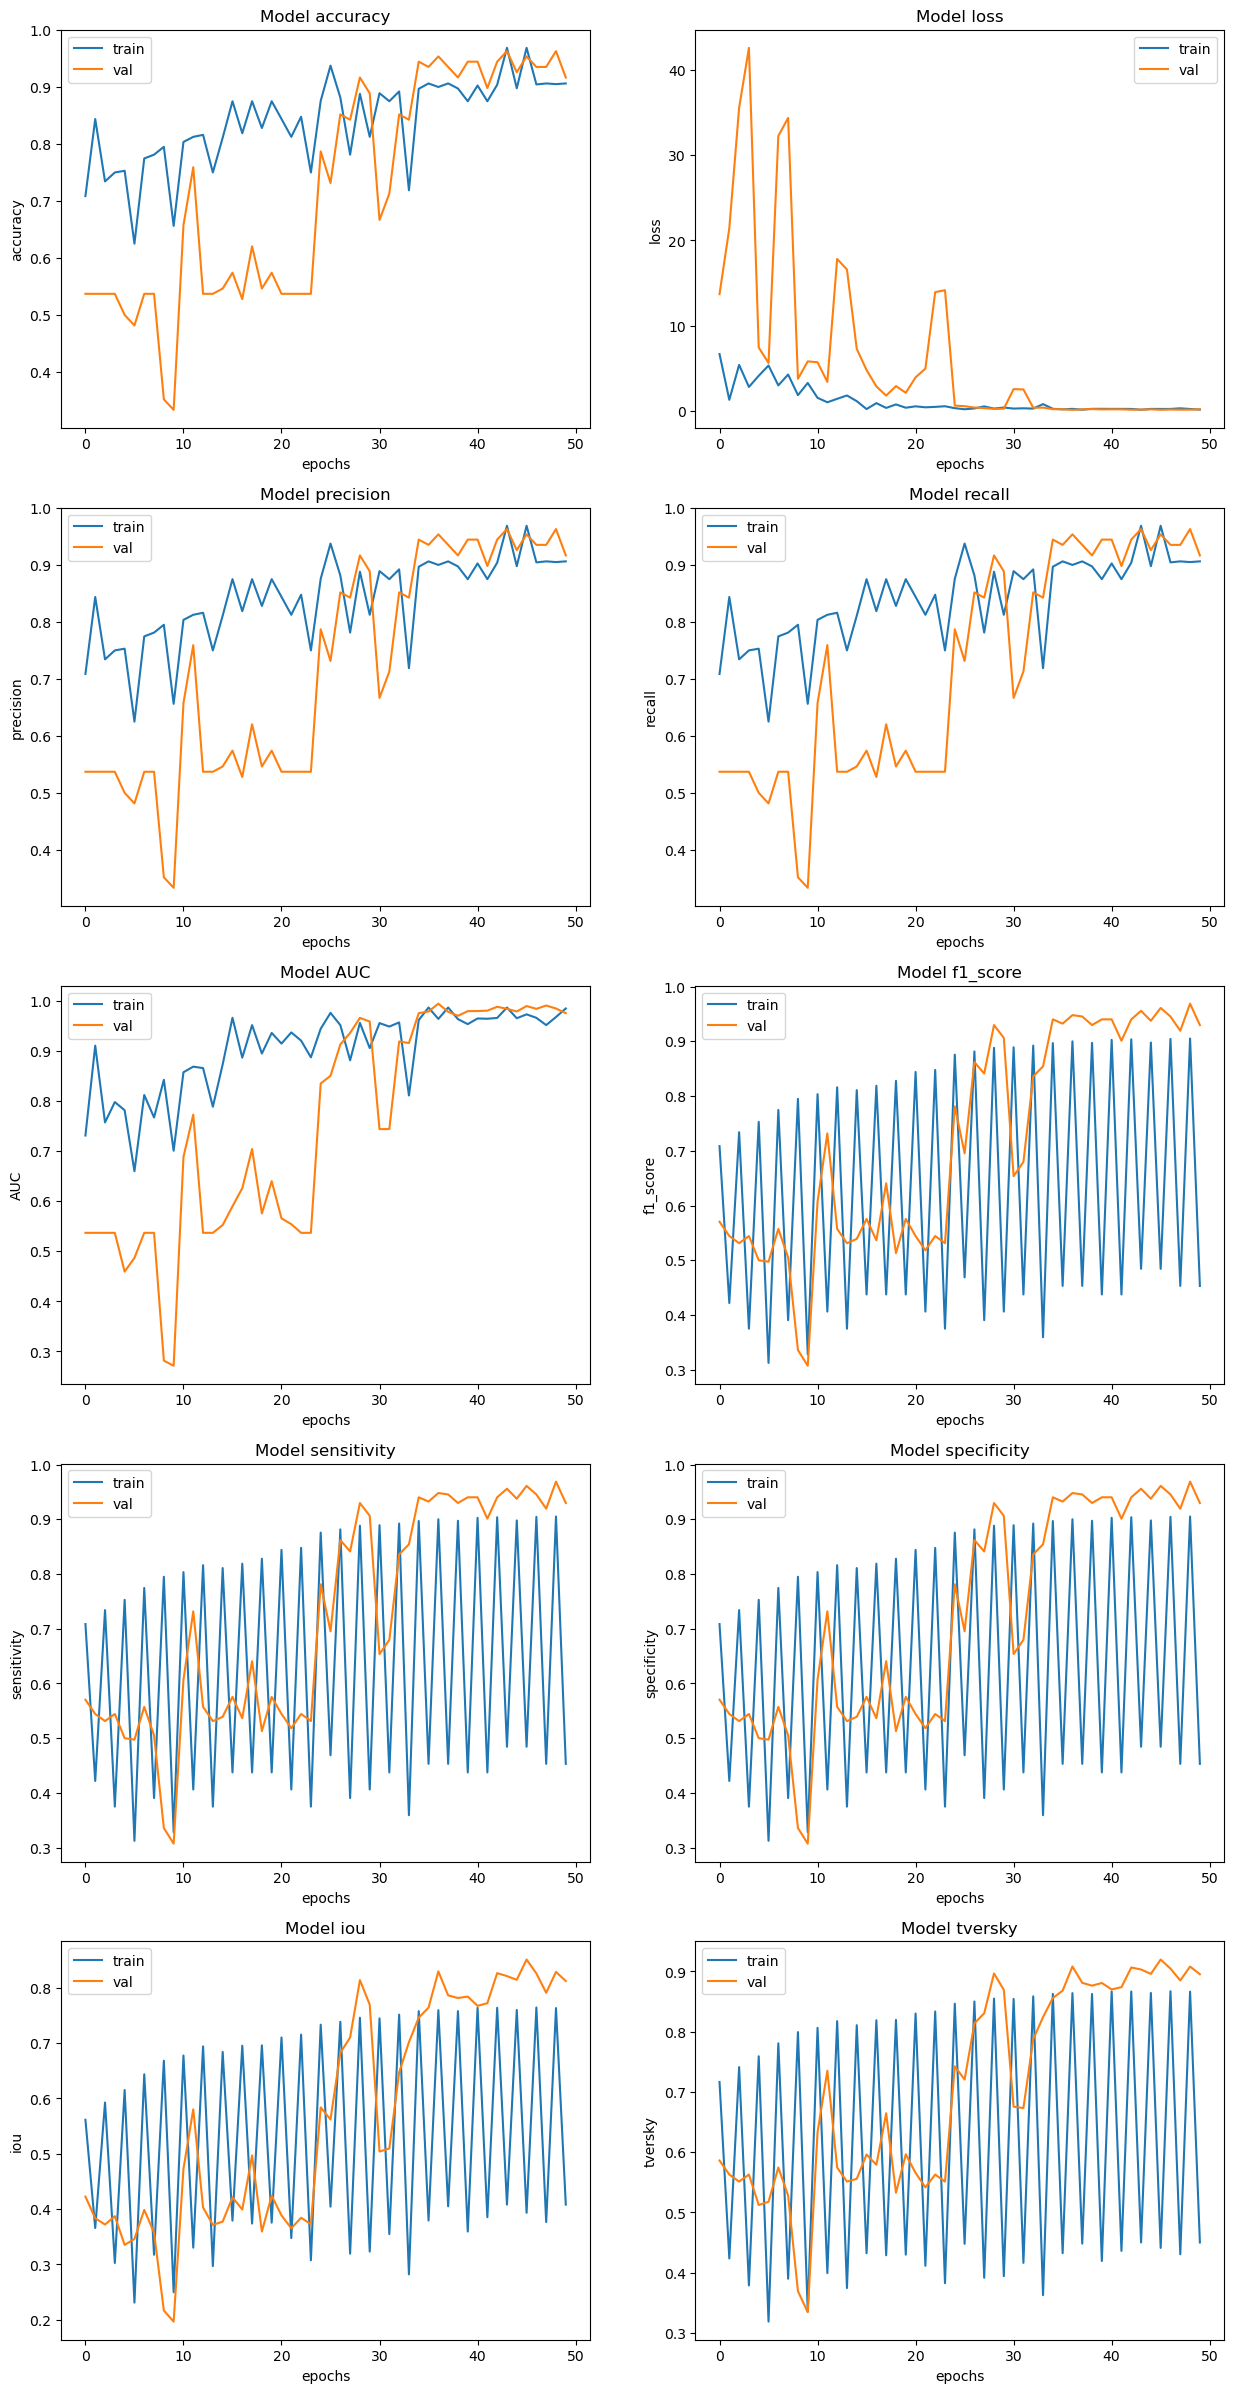

In [195]:
fig, ax = plt.subplots(5, 2, figsize=(15, 30))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall', 'AUC', 'f1_score', 'sensitivity', 'specificity', 'iou', 'tversky']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model-Results.png")

# Preparing Test Data for Evaluation

In [197]:
Test_data = (data_gen.flow(X2_test, Y_test,
                          batch_size=32,  # Reduced batch size to 32
                          seed=27,
                          shuffle=True))

# Evaluating the Model on Test Data

In [199]:
print("Evaluate on test data")

Evaluate on test data


In [201]:
results = model.evaluate(Test_data, batch_size=16, callbacks=callbacks)  # Reduced batch size to 16
print("test loss test acc:", results)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 256ms/step - AUC: 0.9578 - accuracy: 0.8990 - f1_score: 0.8991 - iou: 0.7463 - loss: 0.2615 - precision: 0.8990 - recall: 0.8990 - sensitivity: 0.8991 - specificity: 0.8991 - tversky: 0.8552
test loss test acc: [0.25919291377067566, 0.9058341979980469, 0.9058341979980469, 0.9058341979980469, 0.9594035148620605, 0.9072579741477966, 0.9072580933570862, 0.9072580933570862, 0.7489016652107239, 0.8571594953536987]


2024-08-09 15:57:24.049510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


# Processing Predictions

*Initializing Lists for True and Predicted Labels*

In [204]:
truey = []
predy = []
x = X2_test
y = Y_test

*Making Predictions*

In [206]:
yhat = model.predict(x)

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step

2024-08-09 15:57:33.343746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 392ms/step


*Converting Predictions and True Labels to Lists*

In [208]:
yh = yhat.tolist()
yt = y.tolist()

# Calculating Accuracy

In [211]:
count = 0

for i in range(len(y)):
    yy = max(yh[i])
    yyt = max(yt[i])
    predy.append(yh[i].index(yy))
    truey.append(yt[i].index(yyt))
    if(yh[i].index(yy) == yt[i].index(yyt)):
        count += 1

acc = (count / len(y)) * 100

# Saving Results

In [213]:
np.save('truey', truey)
np.save('predy', predy)
print("Predicted and true label values saved")

Predicted and true label values saved


*Printing Accuracy*

In [215]:
print("Accuracy on test set :" + str(acc) + "%")

Accuracy on test set :92.63050153531218%


# Plot confusion matrix

[[466  38]
 [ 34 439]]


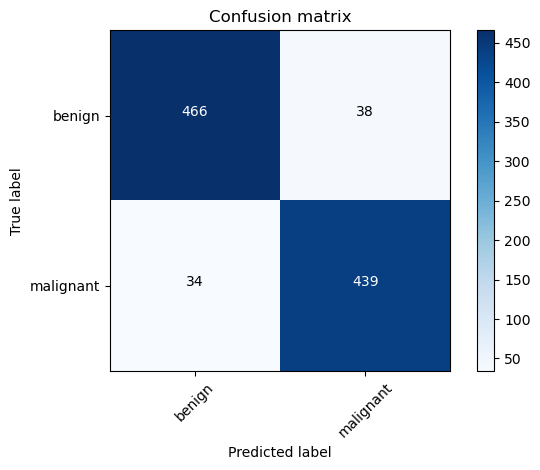

In [217]:
confusion_matrix_img(truey, predy, savename='Confusion Matrix')

# The Percentage of correctly classified images

2024-08-09 15:59:18.914042: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step


2024-08-09 15:59:24.212939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


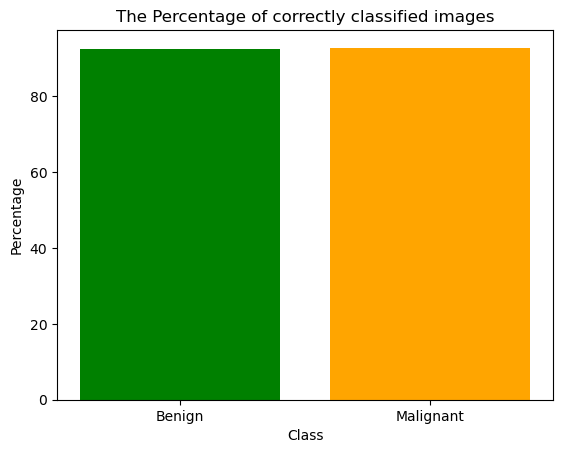

In [325]:
from sklearn.metrics import confusion_matrix
import numpy as np
predictions = model.predict(X2_test)
predictions_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(Y_test, axis=1)
conf_mat = confusion_matrix(true_classes, predictions_classes)

def plotScoresHist(conf_mat):
    scores = pd.DataFrame(conf_mat)
    classes = [0, 1]
    p = [scores[i].to_numpy()[i] / scores[i].to_numpy().sum() * 100 for i in classes]
    plt.bar(["Benign", "Malignant"], p, color=['green', 'orange'])
    plt.title("The Percentage of correctly classified images")
    plt.xlabel('Class')
    plt.ylabel('Percentage')
    plt.xticks(["Benign", "Malignant"])
    plt.show()

plotScoresHist(conf_mat)
